In [1]:
import torch
import pickle

from torchvision import transforms

# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from dynamic_simple.models import dynamicVAE32, beta_from_normalized_beta,prediction_loss
from data.dspritesbT import dSpriteBackgroundDatasetTime

In [2]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)

N = 1 * 32 * 32
M = 10

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])

['betanorm = 0.001 / beta = 0.1']
['betanorm = 0.005 / beta = 0.6']
['betanorm = 0.030 / beta = 3.1']
['betanorm = 0.166 / beta = 17.0']
['betanorm = 0.910 / beta = 93.2']
['betanorm = 5.000 / beta = 512.0']


In [3]:
vae = list()
training_stats = list()
for ii,beta_norm in enumerate(normalized_beta_values):

    # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
    beta_norm_str = '%0.4f' % (beta_norm)
    while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
        beta_norm_str = beta_norm_str[:-1]
    
    trainedpath = 'trained/dynamicvae32_nlatent=10_betanorm=%s_dspritesT_circle_last_500K' % (beta_norm_str)
    trainstatspath = 'trained/dynamicvae32_nlatent=10_betanorm=%s_dspritesT_circle_500K.pkl' % (beta_norm_str)
    
    vae.append(dynamicVAE32(n_latent = 10))
#     checkpoint = torch.load(trainedpath)
#     vae[ii].load_state_dict(checkpoint['model_states']['net'])
# 
#     training_stats.append(pickle.load(open(trainstatspath, 'rb')))

In [4]:
vae[0]

dynamicVAE32(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_enc_mu): Linear(in_features=256, out_features=10, bias=True)
  (fc_enc_mu_pred): Linear(in_features=256, out_features=10, bias=True)
  (fc_enc_logvar): Linear(in_features=256, out_features=10, bias=True)
  (fc_dec): Linear(in_features=10, out_features=256, bias=True)
  (convT4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), paddi

In [5]:

dt = dSpriteBackgroundDatasetTime(transform=transforms.Resize((32,32)),
                                   shapetype='circle',data_dir='data/dsprites-dataset/')

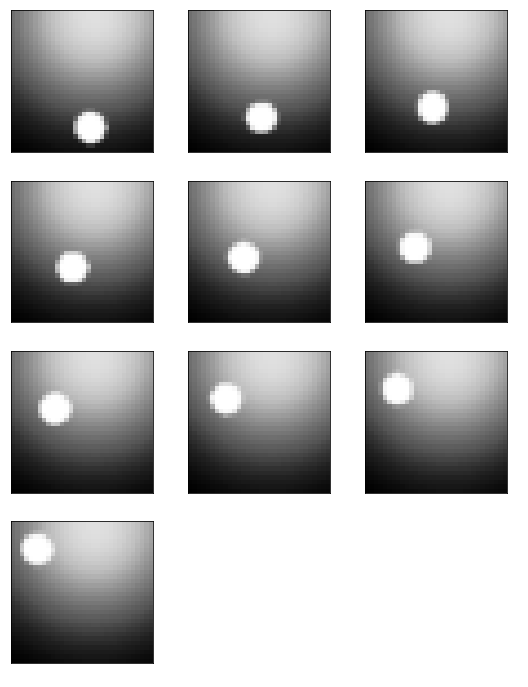

In [6]:
from data.dspritesb import show_images_grid
show_images_grid(dt[3][0])

In [7]:
vae[0].n_frames

10

torch.Size([25, 10, 1, 32, 32])


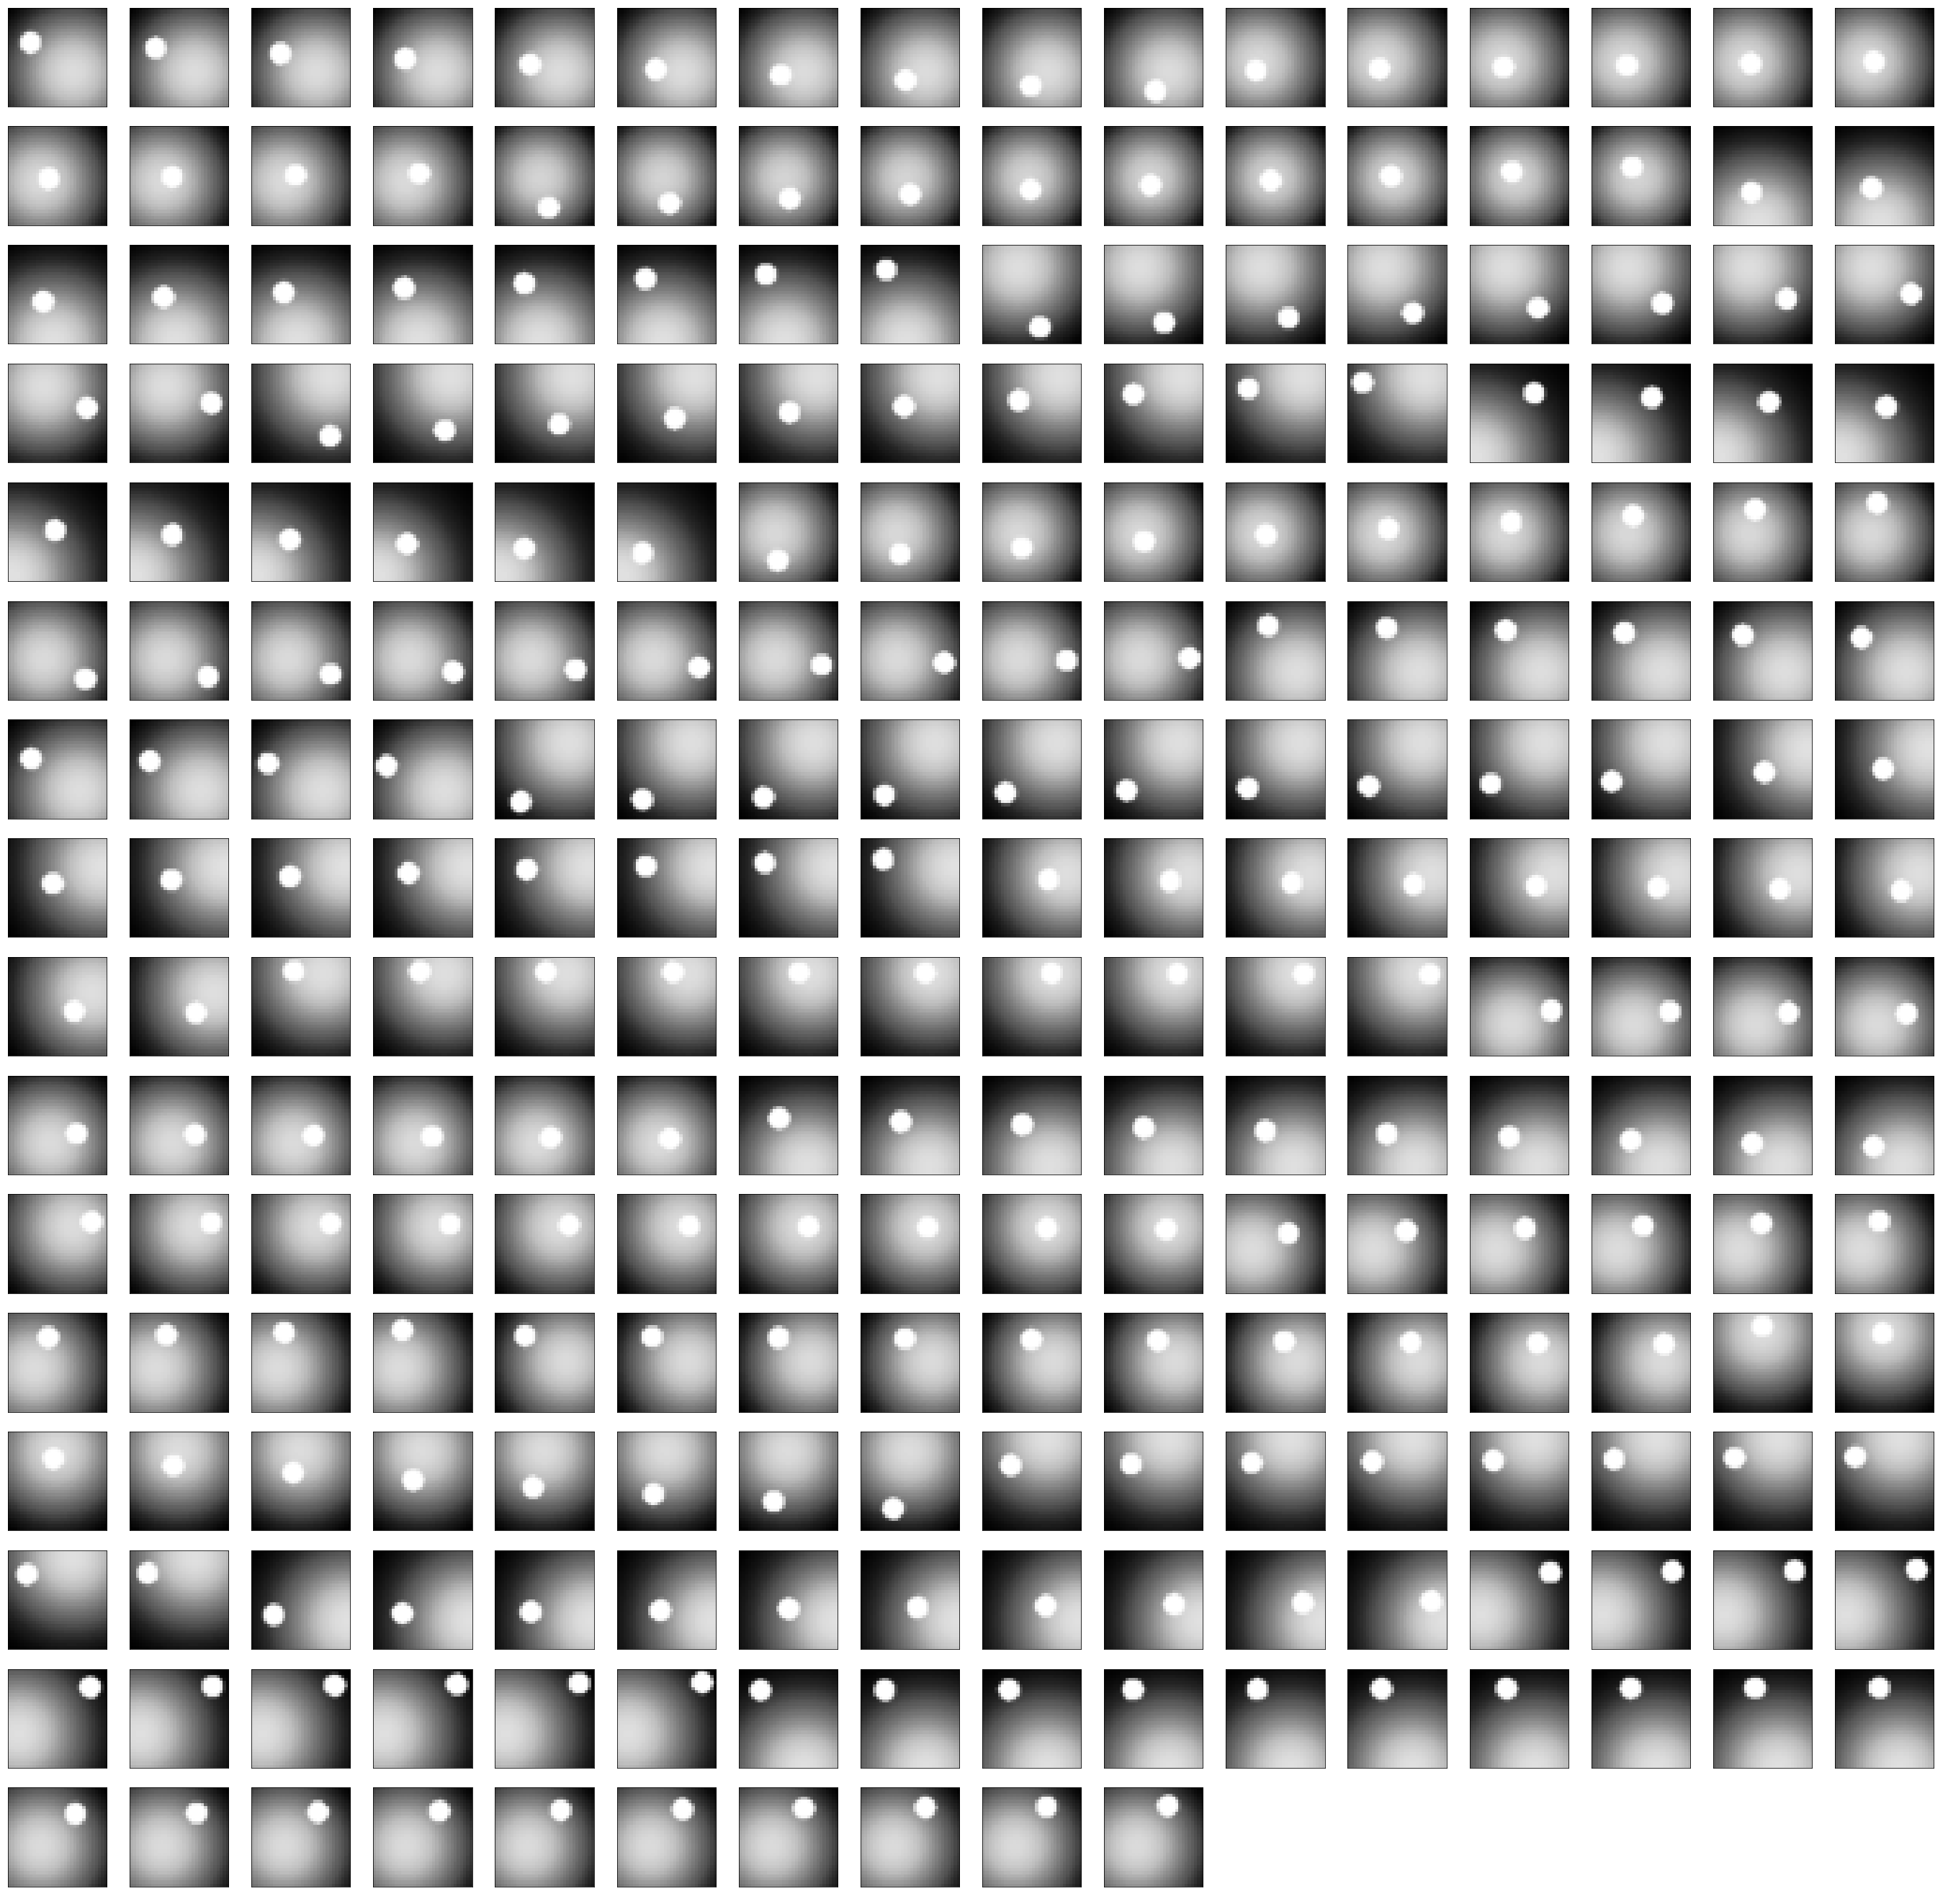

In [8]:
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dt, batch_size=25,shuffle=True, num_workers=4)
for i,[samples,latents] in enumerate(dataloader):
    print(samples.shape)
    show_images_grid(samples.view(25*10,1,32,32))
    break
x = samples

In [9]:
x.shape

torch.Size([25, 10, 1, 32, 32])

In [10]:
x.view(vae[0].n_frames*x.size(0),vae[0].img_channels,32,32).shape

torch.Size([250, 1, 32, 32])

In [11]:
x1=vae[0].conv1(x.view(vae[0].n_frames*x.size(0),vae[0].img_channels,32,32))
x1.shape
x4=vae[0].conv4(vae[0].conv3(vae[0].conv2(x1)))
x4.shape

torch.Size([250, 64, 2, 2])

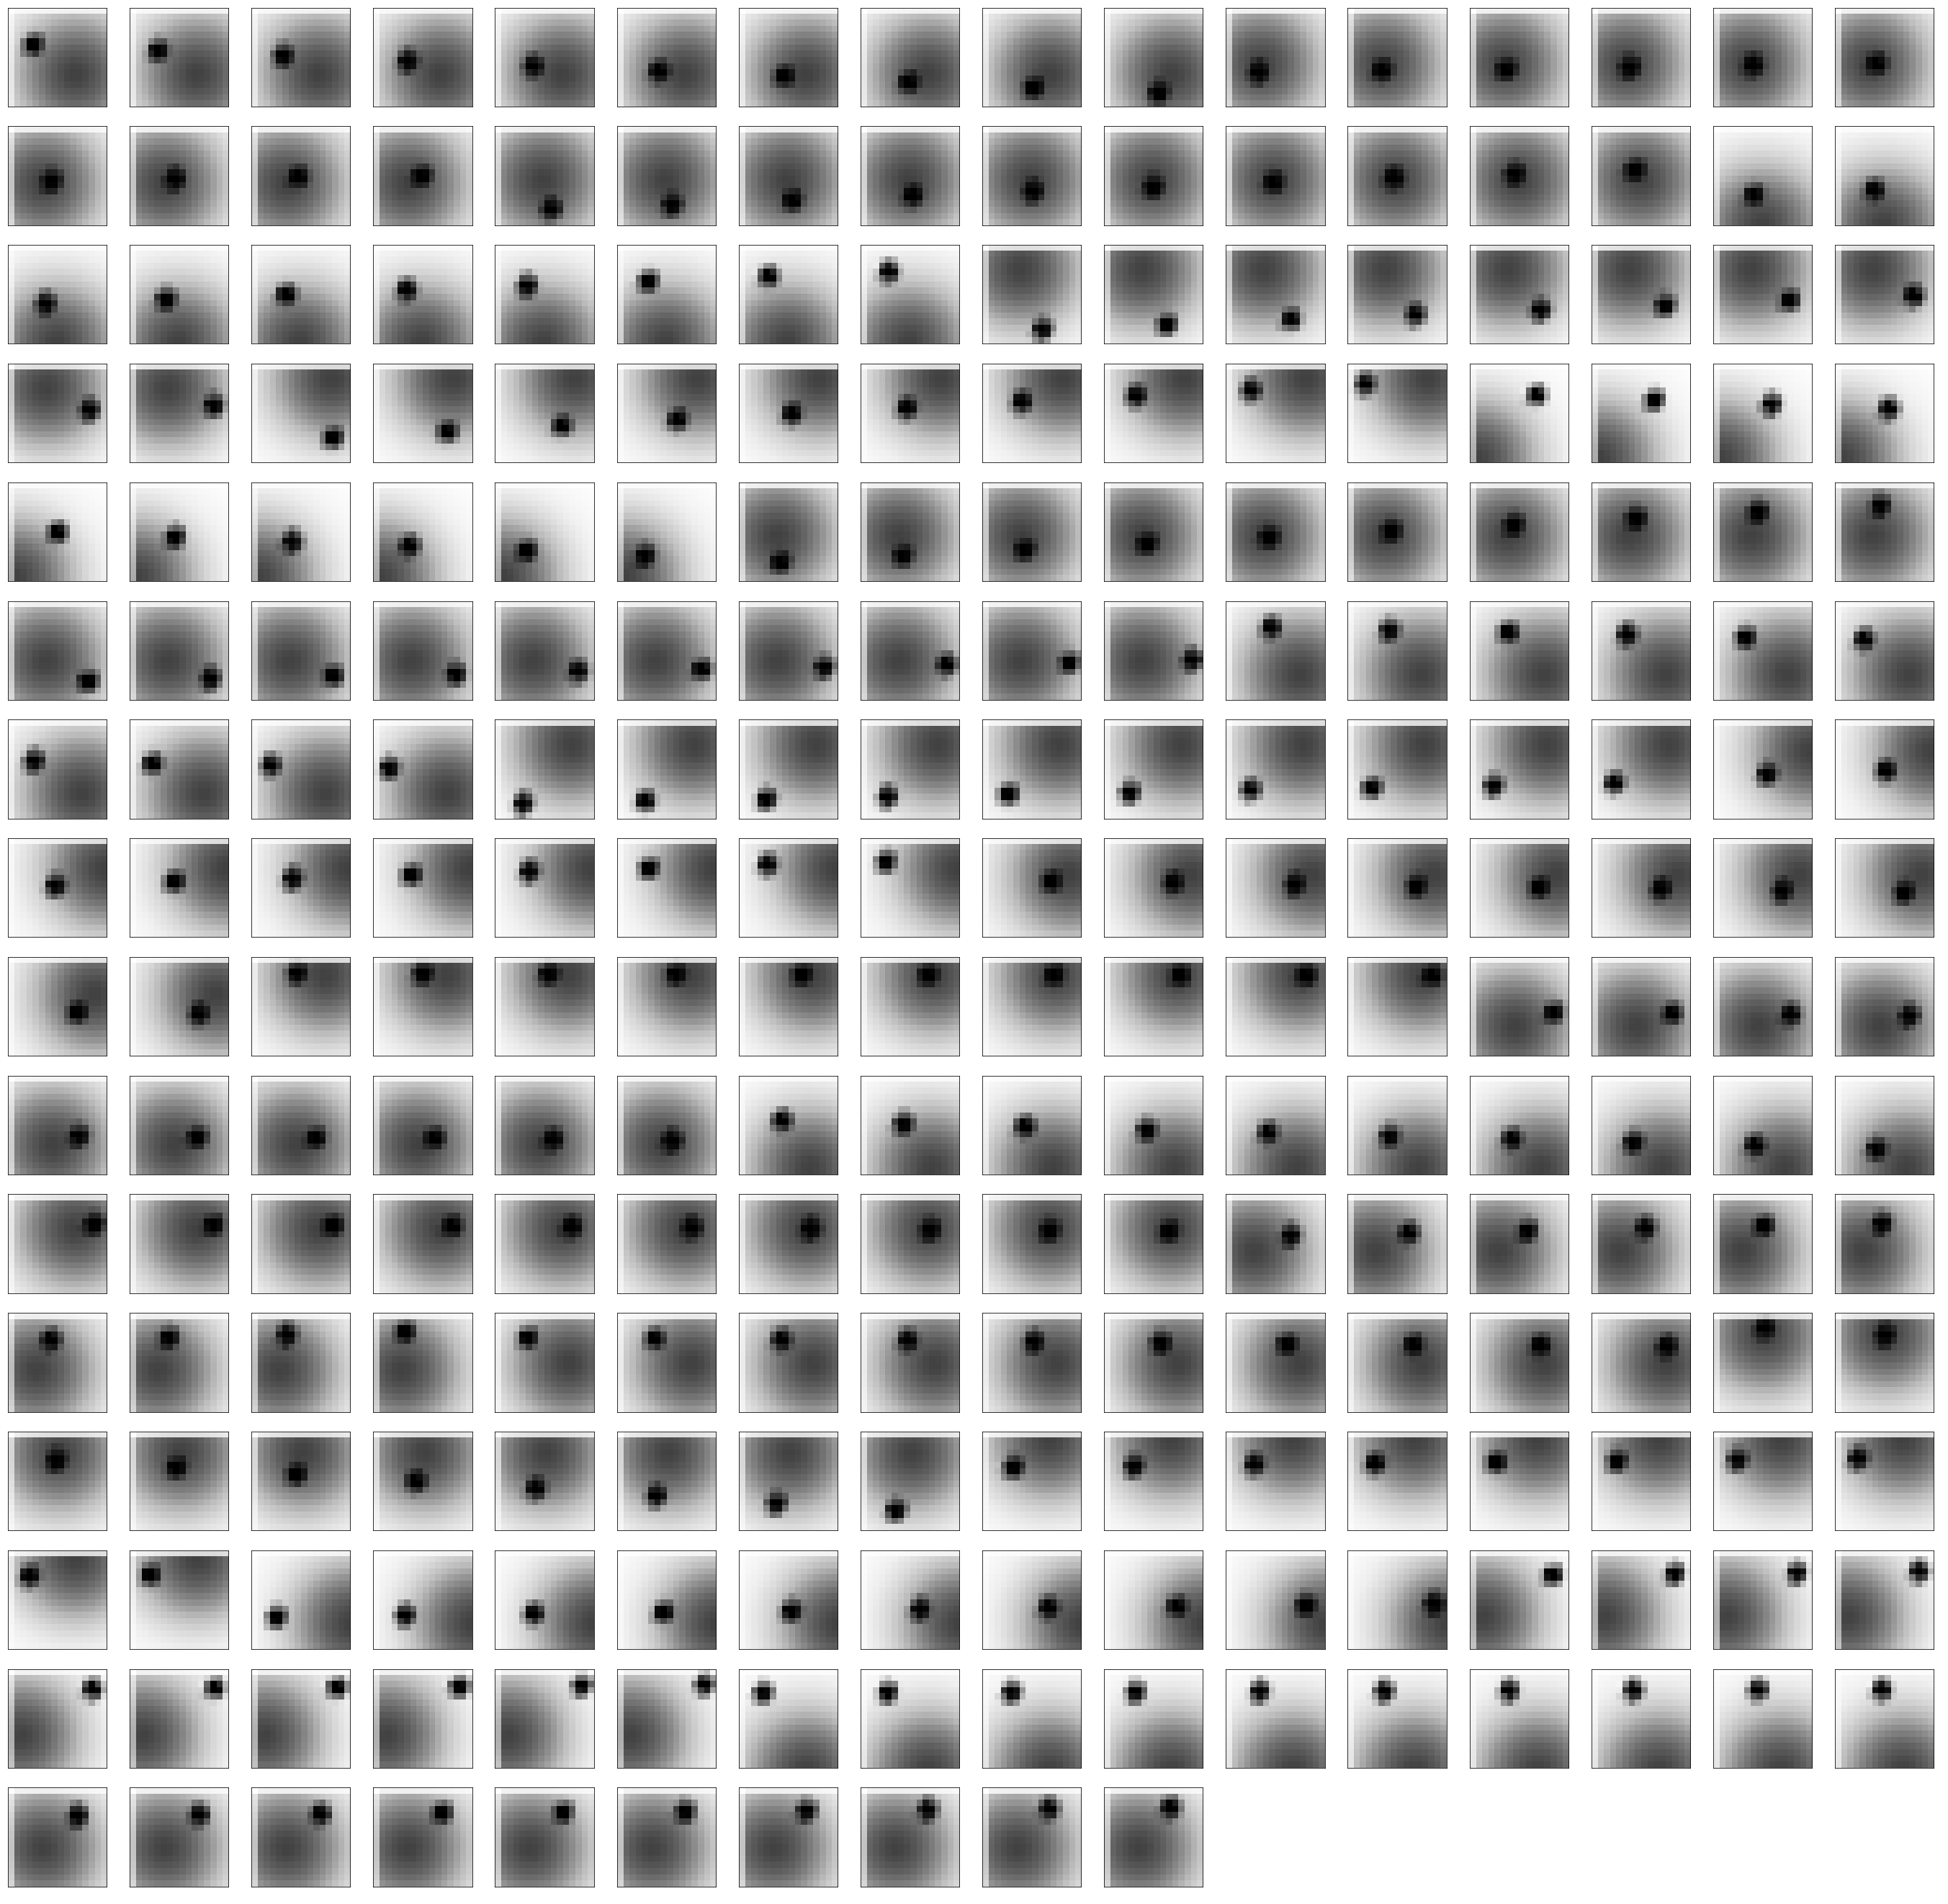

In [12]:
x1show = x1[:,0,:,:].view(-1,1,16,16).detach().numpy()
show_images_grid(x1show)

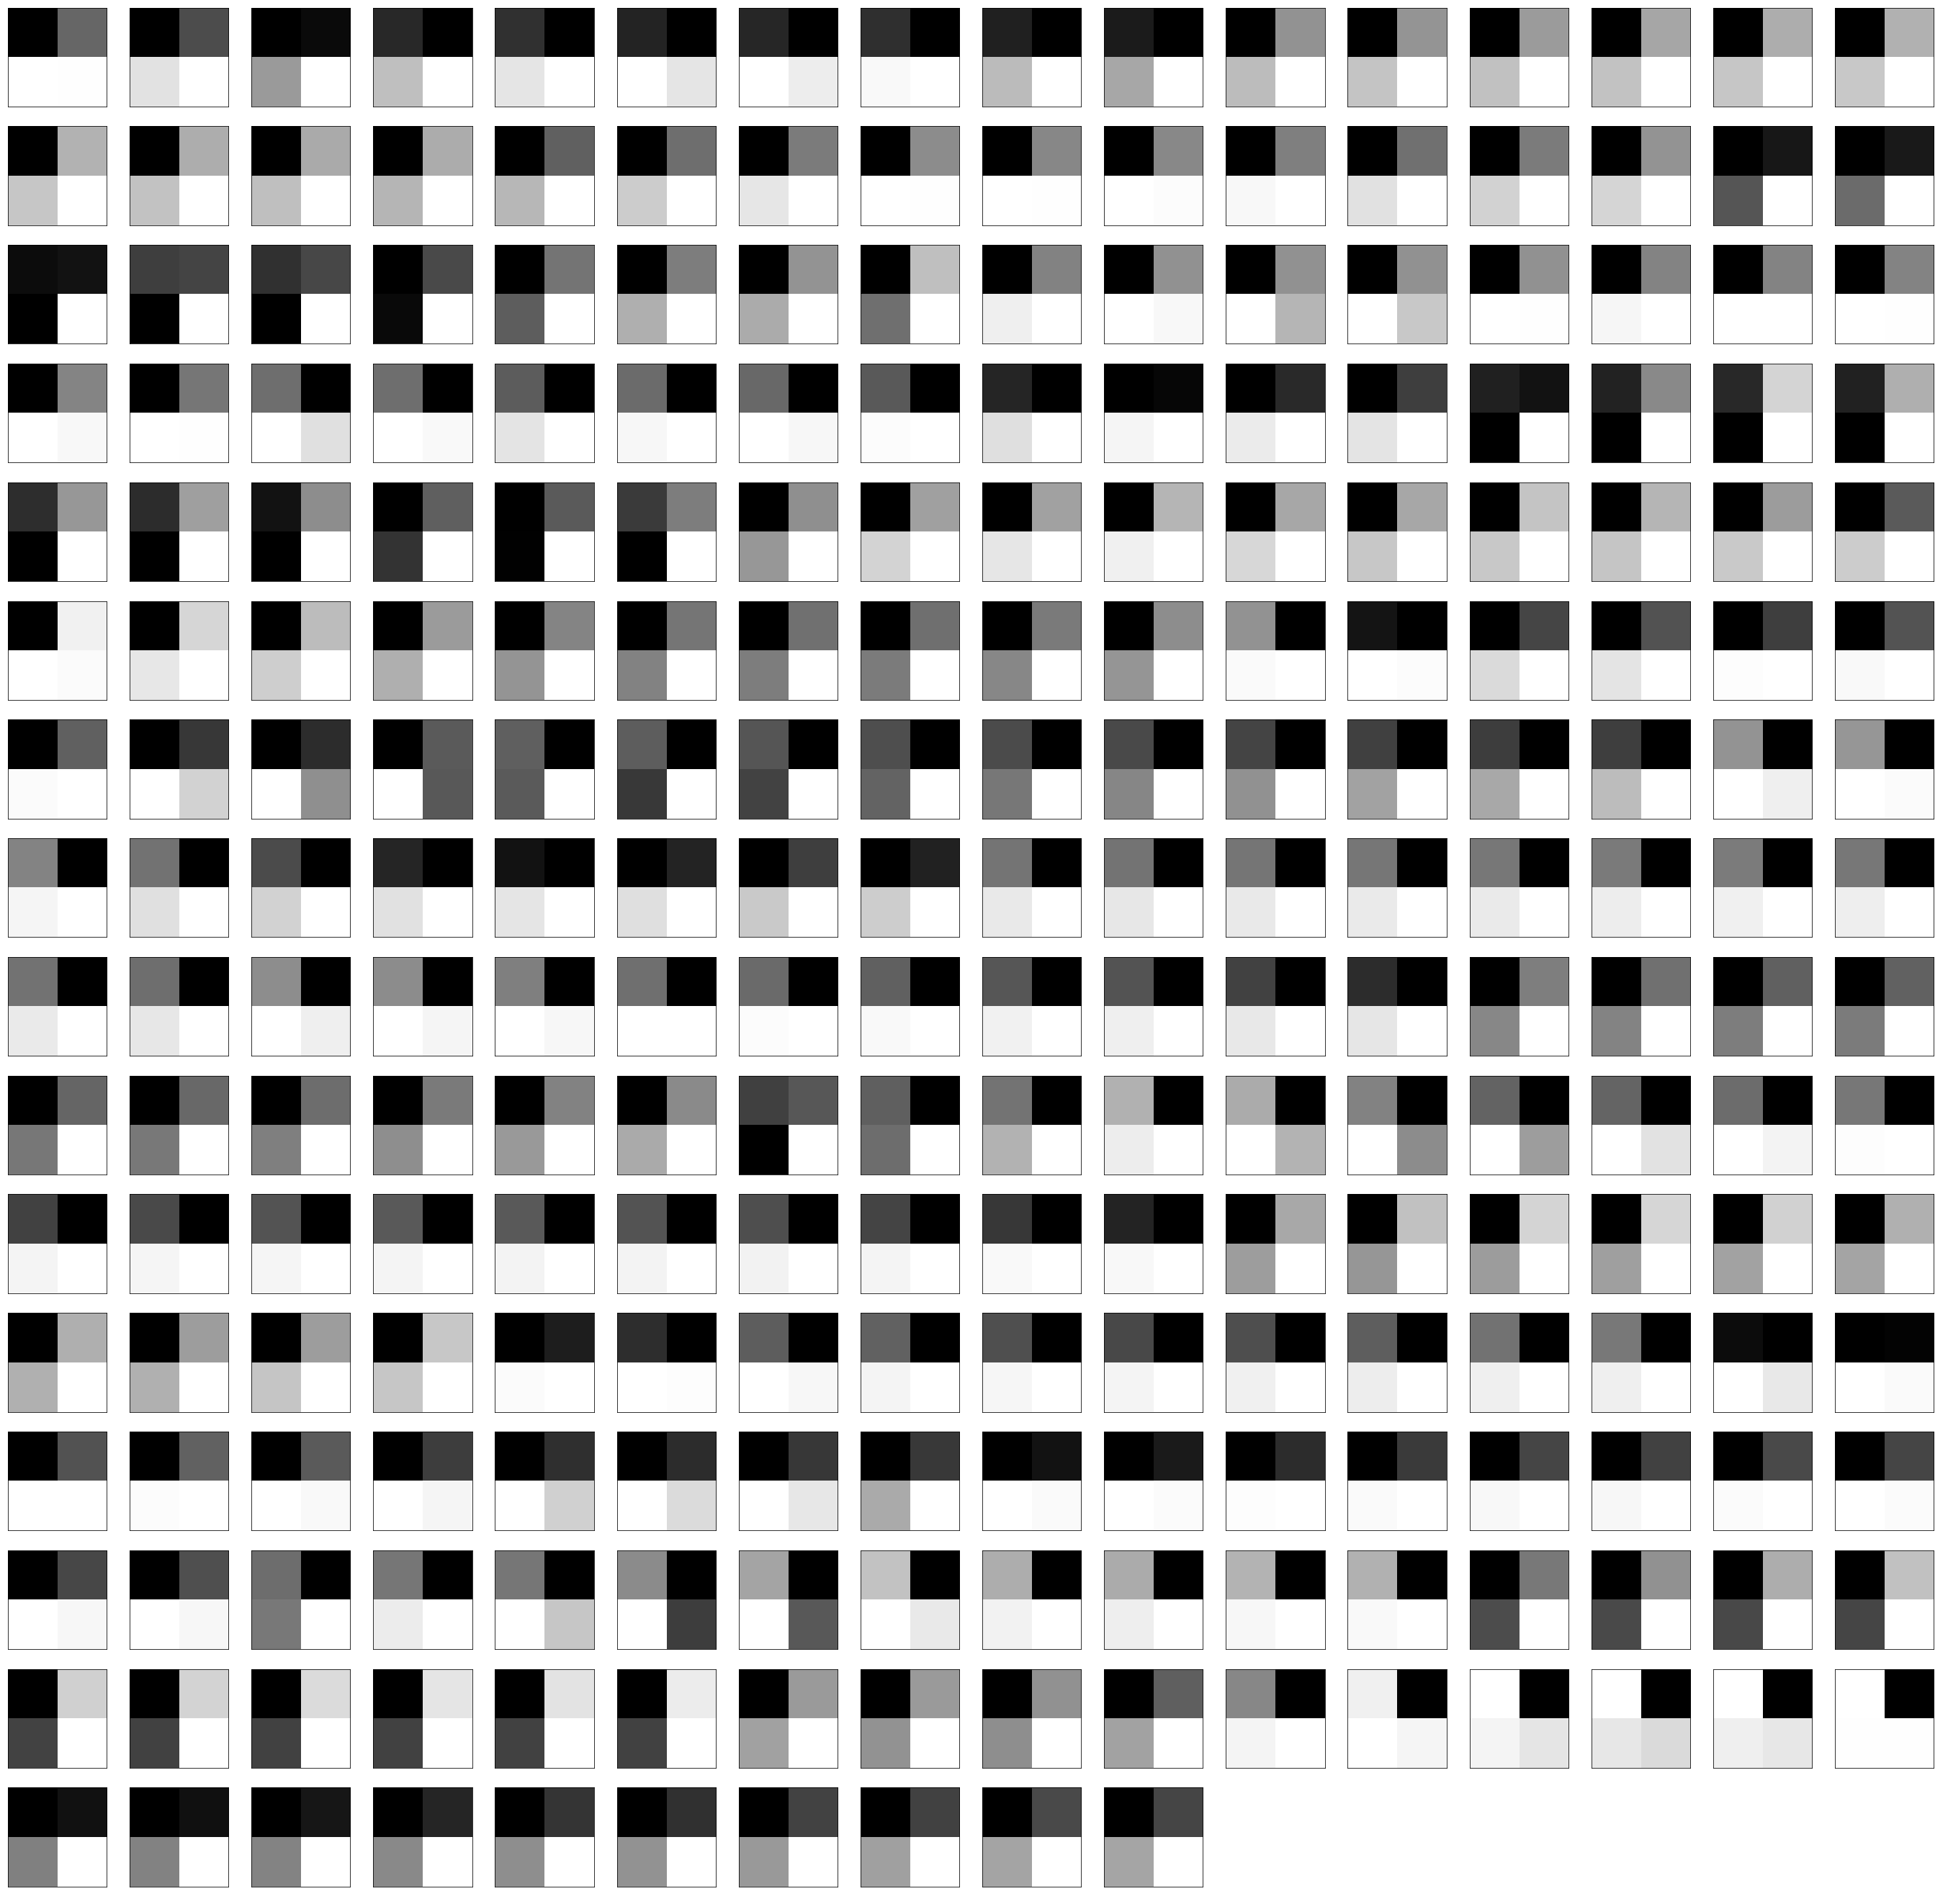

In [13]:
x4show = x4[:,0,:,:].view(-1,1,2,2).detach().numpy()
show_images_grid(x4show)

In [ ]:
vae[0].fc_enc_mu(x4.view(-1,256)).shape

torch.Size([250, 10])

In [ ]:
vae[0].fc_enc_mu_pred(x4.view(-1,256))

tensor([[-0.0520,  0.0289,  0.0246,  ...,  0.0498,  0.0339,  0.0172],
        [-0.0503,  0.0277,  0.0291,  ...,  0.0523,  0.0380,  0.0155],
        [-0.0493,  0.0294,  0.0195,  ...,  0.0539,  0.0342,  0.0110],
        ...,
        [-0.0492,  0.0176,  0.0392,  ...,  0.0540,  0.0424,  0.0099],
        [-0.0499,  0.0174,  0.0396,  ...,  0.0539,  0.0413,  0.0101],
        [-0.0496,  0.0169,  0.0405,  ...,  0.0537,  0.0412,  0.0105]],
       grad_fn=<AddmmBackward>)

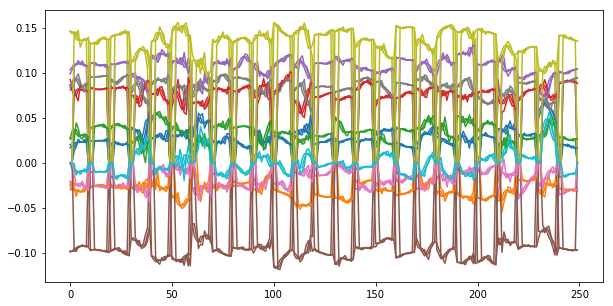

In [ ]:
firstone = vae[0].fc_enc_mu(x4.view(-1,256)).view(25,10,10)
firstone.shape

second = torch.zeros_like(firstone)
pred = torch.zeros_like(firstone)
second[:,:-1,:] = firstone[:,1:,:]
# second
pred[:,2:,:] = second[:,:-2,:] + (second[:,:-2,:]-firstone[:,:-2,:])
# pred[:,1:,:] = np.append(np.zeros((25,2,10)),pred[:,:-2,:],1)
pred

plt.figure(figsize=(10,5))
plt.plot(firstone.detach().numpy().reshape(-1,10))
plt.plot(second.detach().numpy().reshape(-1,10))
plt.plot(pred.detach().numpy().reshape(-1,10))

In [ ]:
mu,_ = vae[0].encode(x)
mu1 = mu.view(-1,vae[0].n_frames,vae[0].n_latent)
mu1.size(0)

25

In [ ]:
recon,mu,logvar,mu_pred = vae[0].forward(x)
recon.size(),mu.size(),logvar.size(),mu_pred.size()

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(torch.Size([25, 10, 1, 32, 32]),
 torch.Size([250, 10]),
 torch.Size([250, 10]),
 torch.Size([250, 10]))

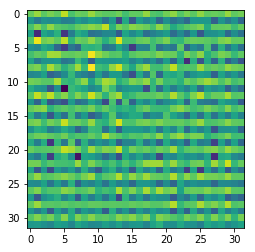

In [ ]:
plt.imshow(recon[0][4][0].detach().numpy())

In [ ]:
mu = mu.view_as(mu_pred)
# mu = mu[2:,:].contiguous().view(-1,10)
# mu_pred=mu_pred[2:,:].contiguous().view_as(mu)
mu_pred.size()

torch.Size([250, 10])

In [ ]:
diff= mu-mu_pred
diff.size()

torch.Size([250, 10])

In [ ]:
torch.matmul(diff[:2:],diff[:2,:].t())

tensor([[0.0070, 0.0071],
        [0.0071, 0.0072]], grad_fn=<MmBackward>)

In [ ]:
# torch.sum(diff[:2,:]*diff[:2,:].t(),0)

In [ ]:
torch.sum(diff[:8:]**2,1)

tensor([7.0223e-03, 7.1933e-03, 8.3377e-06, 1.1315e-05, 8.7406e-06, 6.5491e-06,
        2.5967e-06, 4.5386e-06], grad_fn=<SumBackward2>)

In [ ]:
torch.sum(diff[2,:]*diff[2,:])

tensor(8.3377e-06, grad_fn=<SumBackward0>)

In [ ]:
torch.sum(diff[2,:]**2)

tensor(8.3377e-06, grad_fn=<SumBackward0>)

In [ ]:
prediction_loss(mu,mu_pred)

tensor(0.0071, grad_fn=<MulBackward0>)

In [ ]:
mu.size(),mu_pred.size()

(torch.Size([250, 10]), torch.Size([250, 10]))

In [ ]:
0.5*torch.sum((mu[:2,:]-mu_pred[:2,:])**2)

tensor(0.0071, grad_fn=<MulBackward0>)

In [ ]:
# from main.py
from solver import Solver
import argparse

def str2bool(v):
    # codes from : https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse

    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser(description='dynamic beta VAE')

parser.add_argument('--model', default='dynamicVAE32', type=str, help='which model to train (dynamicVAE32, dynamicVAE64))')

parser.add_argument('--seed', default=1, type=int, help='random seed')
parser.add_argument('--cuda', default=True, type=str2bool, help='enable cuda')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--shuffle', default=True, type=str2bool, help='shuffle training data')
parser.add_argument('--max_iter', default=500000, type=int, help='number of training iterations')

parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--n_latent', default=4, type=int, help='dimension of the latent code')
parser.add_argument('--img_channels', default=1, type=int, help='number of image channels')

parser.add_argument('--beta', default=1, type=float, help='beta for the beta VAE')
parser.add_argument('--beta_is_normalized', default=True, type=str2bool, help='flag whether input beta should be interpreted as normalized beta (default) or as unnormalized beta')
parser.add_argument('--gamma', default=1, type=float, help='gamma hyperparameter for the prediction loss')

parser.add_argument('--dset_dir', default='data', type=str, help='dataset directory')
parser.add_argument('--dataset', default='dsprites_circle', type=str, help='dataset name')
parser.add_argument('--image_size', default=32, type=int, help='image size. now only (32,32) is supported')
parser.add_argument('--num_workers', default=6, type=int, help='dataloader num_workers')

parser.add_argument('--trainstats_gather_step', default=100, type=int, help='numer of iterations after which training stats are gathered and stored')
parser.add_argument('--trainstats_dir', default='trainstats', type=str, help='training statistics directory')

parser.add_argument('--display_step', default=100, type=int, help='number of iterations after which loss data is printed and visdom is updated')

parser.add_argument('--save_step', default=2000, type=int, help='number of iterations after which a checkpoint is saved')

parser.add_argument('--ckpt_dir', default='checkpoints', type=str, help='checkpoint directory')
parser.add_argument('--load_last_checkpoint', default=True, type=str2bool, help='load previous checkpoint if it exists')

_StoreAction(option_strings=['--load_last_checkpoint'], dest='load_last_checkpoint', nargs=None, const=None, default=True, type=<function str2bool at 0x7fa8877096a8>, choices=None, help='load previous checkpoint if it exists', metavar=None)

In [ ]:
args = parser.parse_known_args()[0]

In [ ]:
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [ ]:
net = Solver(args)

=> no checkpoint found at 'checkpoints/dynamicvae32_nlatent=4_betanorm=1_dsprites_circle_last'


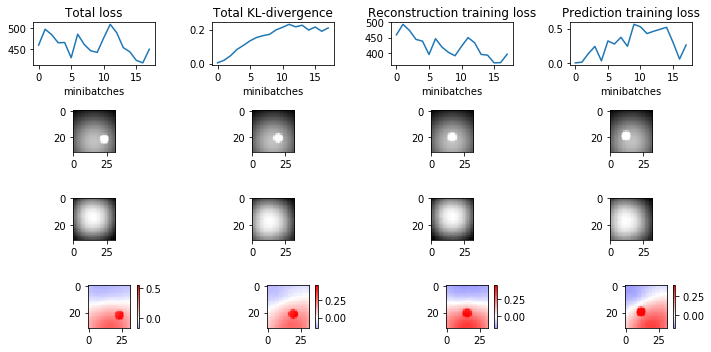

In [ ]:
net.train(plotmode=True)
